# Exploring Zero-Shot Classification with CLIP

In this section, we utilize OpenAI's CLIP model to perform zero-shot image classification. Rather than training on specific categories, CLIP matches images with text prompts using its pre-learned language and vision understanding.


## Setup: Install Required Libraries




In [4]:
!pip install -q git+https://github.com/openai/CLIP.git


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00


## Import Modules and Select Compute Device

We'll now import essential libraries and verify whether a GPU is available to accelerate inference.


In [5]:
# Essential imports for inference and visualization
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Determine whether to use GPU or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Computation device selected: {device}")


Computation device selected: cpu


## Load CLIP Model
We load the ViT-B/32 CLIP model which provides a good balance between performance and speed.

In [8]:
# Load the CLIP vision-language model along with preprocessing pipeline
model, preprocess = clip.load("ViT-B/32", device=device)
print("Successfully loaded CLIP (ViT-B/32) model.")


Successfully loaded CLIP (ViT-B/32) model.


## Create Test Image
Since the online image didn't load, we create a simple red image to demonstrate CLIP's zero-shot classification.

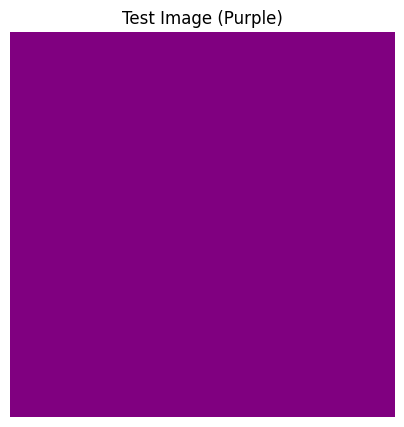

In [9]:
# Create a purple image (symbolic of grapes or creative backgrounds)
width, height = 300, 300
image = Image.new('RGB', (width, height), color='purple')

# Preprocess image for model input
image_input = preprocess(image).unsqueeze(0).to(device)

# Display the purple image
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.title("Test Image (Purple)")
plt.show()

## Perform Zero-Shot Classification
We define text labels describing various objects and use CLIP to compute similarity between the image and text, performing classification without any training.

In [10]:
label_prompts = [
    "a purple object", "a colorful sign", "a shiny surface", "a warning label",
    "a type of fruit", "a vibrant pattern", "an artistic background", "a glossy item"
]

# Tokenize the candidate text descriptions
text_inputs = clip.tokenize(label_prompts).to(device)

# Perform zero-shot prediction using CLIP
with torch.no_grad():
    # Encode image and text into the shared embedding space
    img_features = model.encode_image(image_input)
    txt_features = model.encode_text(text_inputs)

    # Normalize vectors to compute cosine similarity
    img_features /= img_features.norm(dim=-1, keepdim=True)
    txt_features /= txt_features.norm(dim=-1, keepdim=True)

    # Calculate similarity and get top predictions
    similarity_scores = (100.0 * img_features @ txt_features.T).softmax(dim=-1)
    top_scores, top_indices = similarity_scores[0].topk(5)

# Print classification results
print("Top matching descriptions and confidence scores:")
for score, idx in zip(top_scores, top_indices):
    print(f"{label_prompts[idx]:30s}: {score.item() * 100:.1f}%")

Top matching descriptions and confidence scores:
a purple object               : 95.5%
a vibrant pattern             : 1.9%
a shiny surface               : 1.7%
an artistic background        : 0.4%
a glossy item                 : 0.3%


## Visualize Zero-Shot Results
Create a horizontal bar chart showing the top 5 predictions with their confidence scores for better visualization.

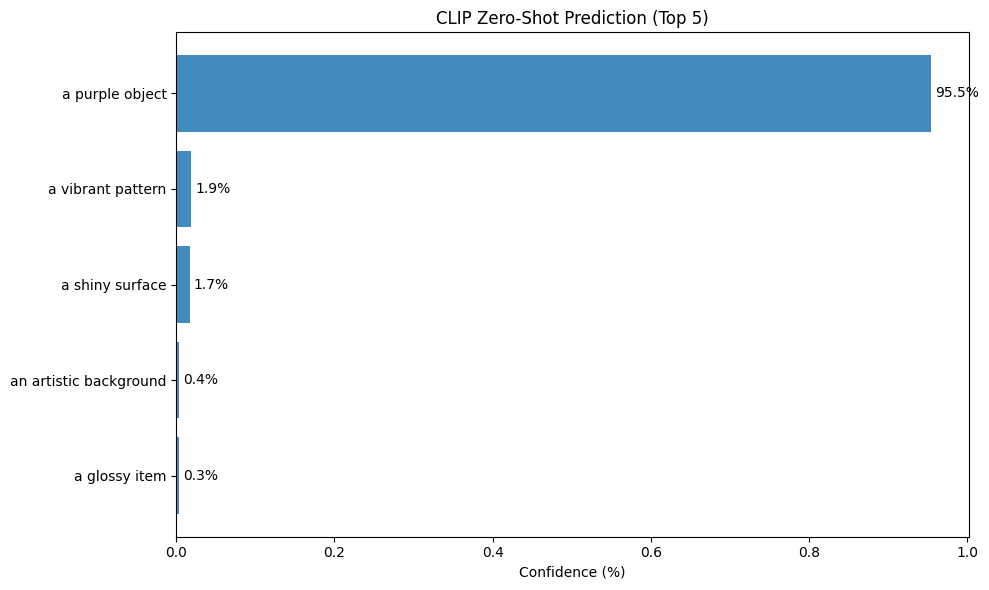

In [12]:
# Visualize top predictions from CLIP using a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define positions and bar heights
positions = np.arange(len(top_indices))
scores = [score.item() for score in top_scores]
labels = [label_prompts[i] for i in top_indices]

# Create the horizontal bar chart
ax.barh(positions, scores, align='center', alpha=0.85)
ax.set_yticks(positions)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # Highest score on top

# Axis labels and title
ax.set_xlabel('Confidence (%)')
ax.set_title('CLIP Zero-Shot Prediction (Top 5)')

# Annotate each bar with its percentage value
for i, score in enumerate(scores):
    ax.text(score + 0.005, i, f'{score * 100:.1f}%', va='center')

plt.tight_layout()
plt.show()


## Test Zero-Shot on Multiple Colors
Demonstrate CLIP's ability to classify different colored images without any training on these specific examples.

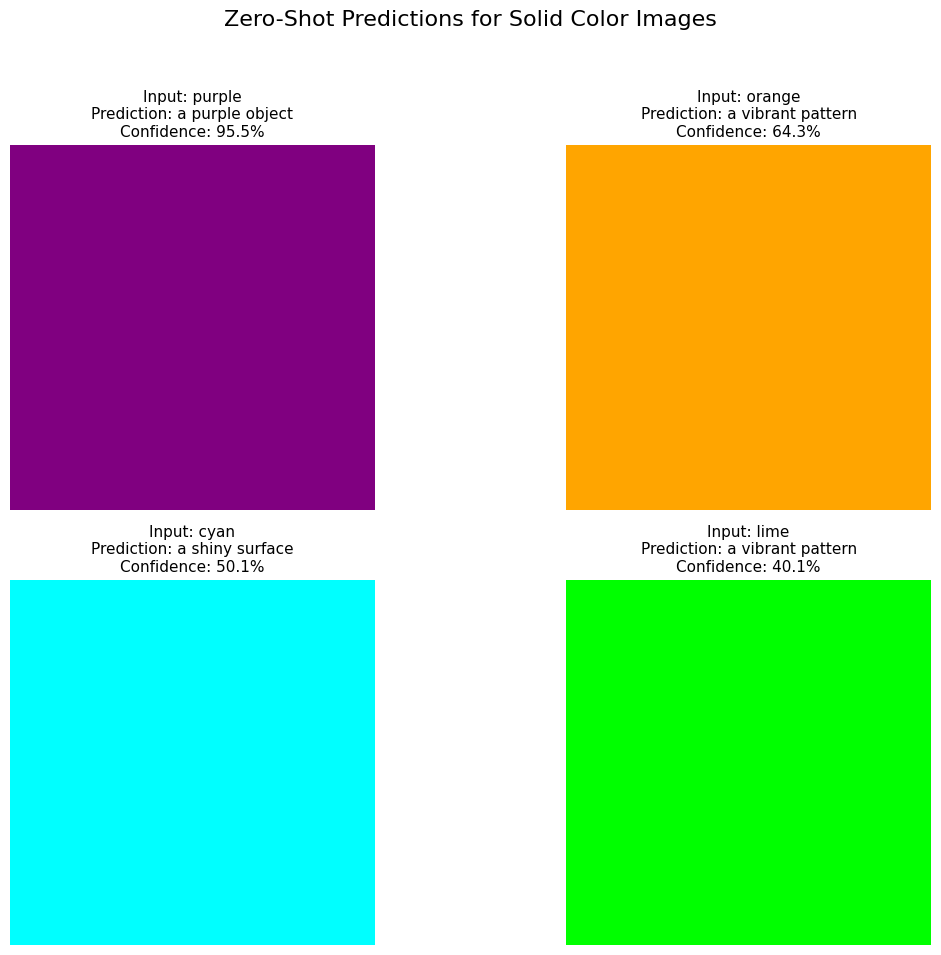

In [13]:
# Evaluate CLIP on a set of solid color images using updated layout and labels
from matplotlib.gridspec import GridSpec

test_colors = ['purple', 'orange', 'cyan', 'lime']
fig = plt.figure(figsize=(12, 10))
grid = GridSpec(2, 2, figure=fig)
axes = [fig.add_subplot(grid[i]) for i in range(4)]

for i, color in enumerate(test_colors):
    # Create a solid color image
    color_img = Image.new('RGB', (100, 100), color=color)
    input_tensor = preprocess(color_img).unsqueeze(0).to(device)

    # Run CLIP prediction
    with torch.no_grad():
        feat = model.encode_image(input_tensor)
        feat /= feat.norm(dim=-1, keepdim=True)
        sim = (100.0 * feat @ txt_features.T).softmax(dim=-1)
        score, label_idx = sim[0].topk(1)

    # Display results
    axes[i].imshow(color_img)
    axes[i].set_title(
        f'Input: {color}\nPrediction: {label_prompts[label_idx.item()]}\nConfidence: {score.item() * 100:.1f}%',
        fontsize=11
    )
    axes[i].axis('off')

plt.suptitle("Zero-Shot Predictions for Solid Color Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
